In [1]:
import numpy as np
np.random.seed(666)
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
%matplotlib inline

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split, cross_val_score, KFold

from scipy.stats import zscore

In [2]:
train_data = pd.read_csv("train.csv", index_col='Id')
print(train_data.shape)
train_data.head()

(1460, 80)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
test_data = pd.read_csv("test.csv", index_col='Id')
sample = pd.read_csv("sample_submission.csv")

In [4]:
y = train_data['SalePrice']
train_data.drop(columns='SalePrice', inplace=True)

# EDA & Preprocessing

Посмотрим на статистику и гистограмму цена продажи

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

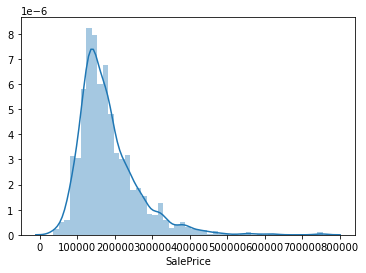

In [5]:
sns.distplot(y)
y.describe()

In [6]:
y = np.log1p(y)

count    1460.000000
mean       12.024057
std         0.399449
min        10.460271
25%        11.775105
50%        12.001512
75%        12.273736
max        13.534474
Name: SalePrice, dtype: float64

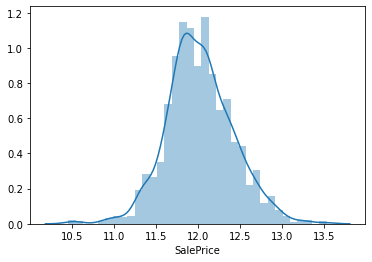

In [7]:
sns.distplot(y)
y.describe()

Видно, что целевой признак имеет длинный правый хвост. Возможно имеет смысл обрезать датасет и убрать крайние правые объекты

Создадим таблицу, которая показывает процент "пропущенности" каждой колонки.

In [8]:
nans = pd.DataFrame(
    {
        'Nans': train_data.isna().sum() / train_data.shape[0],
        'Dtype': train_data.dtypes,
    }
).sort_values('Nans', ascending=False)
nans.head(10)

,Nans,Dtype
PoolQC,0.995205,object
MiscFeature,0.963014,object
Alley,0.937671,object
Fence,0.807534,object
FireplaceQu,0.472603,object
LotFrontage,0.177397,float64
GarageType,0.055479,object
GarageYrBlt,0.055479,float64
GarageQual,0.055479,object
GarageCond,0.055479,object


 Уберем те колонки, в которых пропусков больше 0.06. В остальных заполним средним, если это числовая колонка или модой, если object

In [9]:
train_data.drop(columns=nans.loc[nans['Nans'] > 0.06].index, inplace=True)
test_data.drop(columns=nans.loc[nans['Nans'] > 0.06].index, inplace=True)

In [10]:
for column in train_data.columns:
    if train_data[column].dtype == np.dtype('object'):
        train_data[column] = train_data[column].fillna(train_data[column].mode().iloc[0])
    else:
        train_data[column] = train_data[column].fillna(train_data[column].mean())
    
    if test_data[column].dtype == np.dtype('object'):
        test_data[column] = test_data[column].fillna(test_data[column].mode().iloc[0])
    else:
        test_data[column] = test_data[column].fillna(test_data[column].mean())

Нарисуем хэтмапу по корреляции

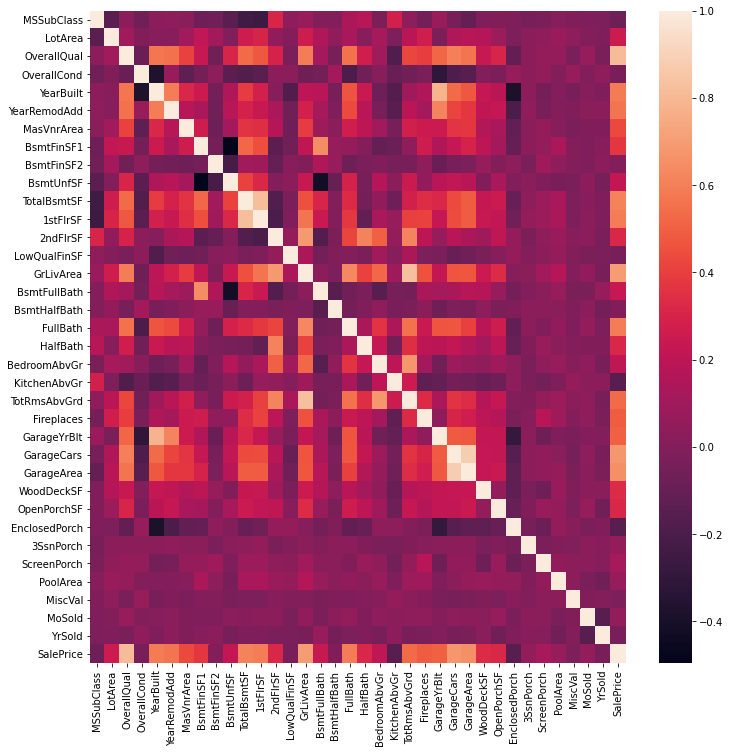

In [11]:
plt.figure(figsize=(12, 12))
for_corr = pd.concat((train_data, y), axis=1)
sns.heatmap(for_corr.corr());

Видно, что две пары: GarageCars - GarageArea, TotalBsmtSF - 1stFlrSF сильно коррелируют и надо убрать по одному из каждой пары, чтобы уменьшить мультиколленионароность между признаками

In [12]:
train_data.drop(columns=['GarageCars', 'TotalBsmtSF'], inplace=True)
test_data.drop(columns=['GarageCars', 'TotalBsmtSF'], inplace=True)

Также на будущее составим список тех признаков, которые слабо коррелируют с целевым

In [13]:
weak_features = list(for_corr.corr()['SalePrice']
                     [for_corr.corr()['SalePrice'].abs() < 0.2].index)

In [14]:
str_features = list(train_data.columns[train_data.dtypes == np.dtype('O')])

In [15]:
train_data.drop(columns=str_features, inplace=True)
test_data.drop(columns=str_features, inplace=True)

In [16]:
train_data = train_data[(np.abs(zscore(train_data)) < 3).all(axis=1)]

# fit predict 300k/sec

In [17]:
X = train_data
y = y.loc[train_data.index]

In [18]:
simple_model = LinearRegression()

In [19]:
scorers = cross_val_score(simple_model, X, y, scoring='neg_root_mean_squared_error', cv=5)
scorers *= -1
print(f'mean: {scorers.mean():5f}; std: {scorers.std():5f}')

mean: 0.121395; std: 0.008341


In [20]:
simple_model.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [21]:
final_model = simple_model

# Submit

In [22]:
preds = final_model.predict(test_data)
sample['SalePrice'] = np.expm1(preds)
sample.to_csv('submission.csv', index=False)